# Molecule: building molecules, geometry specification, and returning molecular properties

This tutorial provides an overview on creating and manipulating molecule objects in PSI4, illustrated with an example parameterization of the Lennard-Jones potential for Helium dimer.

In [1]:
import psi4

Unlike in <span style="font-variant: small-caps"> Psi4 </span> input files, defining a molecule in Python is done by passing the molecular coordinates as a triple-quoted string to the [`psi4.geometry()`](http://psicode.org/psi4manual/master/api/psi4.driver.geometry.html#psi4.driver.geometry "API Details") function:

In [2]:
he = psi4.geometry("""
He
""")

Here, not only does the variable `he` refer to the helium molecule, but also an instance of the [`psi4.core.Molecule`](http://psicode.org/psi4manual/master/psi4api.html#psi4.core.Molecule "Go to API")
class in <span style='font-variant: small-caps'> Psi4</span>; this will be discussed in more detail later.  For a more
complicated system than an isolated atom, the coordinates can be given in Cartesian or Z-Matrix formats:

In [4]:
h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

Information like the molecular charge, multiplicity, and units are assumed to be 0, 1, and Angstroms, respectively, if not specified within the molecule definition.  This is done by adding one or more [molecule keywords](http://psicode.org/psi4manual/master/psithonmol.html#molecule-keywords "Go to Documentation") to the geometry string used to define the molecule.  Additionally, <span style="font-variant: small-caps"> Psi4 </span> can detect molecular symmetry, or it can be specified manually.  For example, to define a doublet water cation in $C_{2V}$ symmetry using lengths in Bohr,

In [3]:
doublet_h2o_cation = psi4.geometry("""
1 2
O
H 1 1.814
H 1 1.814 2 104.5

units bohr
symmetry c2v
""")

where the line `1 2` defines the charge and multiplicity, respectively.  For systems of non-bonded fragments, the coordinates of each fragment are separated by a double-hyphen `"--"`; this allows for one fragment to be defined with Cartesian and another to be defined with Z-Matrix. For example, the hydronium-benzene complex can be defined with: 

In [5]:
hydronium_benzene = psi4.geometry("""
0 1
C          0.710500000000    -0.794637665924    -1.230622098778
C          1.421000000000    -0.794637665924     0.000000000000
C          0.710500000000    -0.794637665924     1.230622098778
C         -0.710500000000    -0.794637665924     1.230622098778
H          1.254500000000    -0.794637665924    -2.172857738095
H         -1.254500000000    -0.794637665924     2.172857738095
C         -0.710500000000    -0.794637665924    -1.230622098778
C         -1.421000000000    -0.794637665924     0.000000000000
H          2.509000000000    -0.794637665924     0.000000000000
H          1.254500000000    -0.794637665924     2.172857738095
H         -1.254500000000    -0.794637665924    -2.172857738095
H         -2.509000000000    -0.794637665924     0.000000000000
-- 
1 1
X  1  CC  3  30   2  A2
O  13 R   1  90   2  90
H  14 OH  13 TDA  1  0
H  14 OH  15 TDA  13 A1
H  14 OH  15 TDA  13 -A1

CC    = 1.421
CH    = 1.088
A1    = 120.0
A2    = 180.0
OH    = 1.05
R     = 4.0
units angstrom
""")

For non-bonded fragments, the charge and multiplicity should be given explicitly for each fragment.  If not, the 
charge and multiplicity given (or inferred) for the first fragment is assumed to be the same for all fragments.  In 
addition to defining the coordinates outright, we have used variables within the geometry specification strings to
define bond lengths, angles, and dihedrals in the molecule.  Similarly, we could define the X, Y, or Z Cartesian
coordinate for any atom in our molecule. 

In order to define these variables after the molecule is built, as opposed to within the geometry specification 
itself, there are several ways to do so; one of which will be illustrated in the Lennard-Jones potential example 
below. 

When a Psi4 molecule is first built using ``psi4.geometry()``, it is in an unfinished state, as a user may wish to 
tweak the molecule. This can be solved by calling [``psi4.Molecule.update_geometry()``](http://psicode.org/psi4manual/master/psi4api.html#psi4.core.Molecule.update_geometry "Go to API"). This will update the molecule and restore sanity 
to chemistry.  

In [6]:
h2cch2 = psi4.geometry("""
H
C 1 HC
H 2 HC 1 A1
C 2 CC 3 A1 1 D1
H 4 HC 2 A1 1 D1
H 4 HC 2 A1 1 D2

HC = 1.08
CC = 1.4
A1 = 120.0
D1 = 180.0
D2 = 0.0
""")

print("Ethene has %d atoms" % h2cch2.natom())


h2cch2.update_geometry()
print("Ethene has %d atoms" % h2cch2.natom())

Ethene has 6 atoms
Ethene has 6 atoms


Finally, one can obtain useful information from a molecule by invoking one of several [`psi4.core.Molecule`](http://psicode.org/psi4manual/master/psi4api.html#psi4.core.Molecule "Go to Documentation") class methods on the molecule of interest.  For example, if we were interested in verifying that our doublet water cation from above is, in fact, a doublet, we could invoke
~~~python
doublet_h2o_cation.multiplicity()
~~~
Below, some useful Molecule class methods are tabulated; please refer to the documentation for more details.

| Method | Description |
|--------|-------------|
| [center_of_mass()](http://psicode.org/psi4manual/master/psi4api.html#psi4.core.Molecule.center_of_mass "Go to Documentation") | Computes center of mass of molecule |
| [molecular_charge()](http://psicode.org/psi4manual/master/psi4api.html#psi4.core.Molecule.molecular_charge "Go to Documentation") | Gets the molecular charge |
| [multiplicity()](http://psicode.org/psi4manual/master/psi4api.html#psi4.core.Molecule.multiplicity "Go to Documentation") | Gets the total multiplicity | 
| [nuclear_repulsion_energy()](http://psicode.org/psi4manual/master/psi4api.html#psi4.core.Molecule.nuclear_repulsion_energy "Go to Documentation") | Computes the nuclear repulsion energy of the molecule |

## Example: Fitting Lennard-Jones Parameters from Potential Energy Scan

In this example, we will compute and fit a potential energy curve for the Helium dimer.  To begin with, let's create a string representation for our He dimer in Z-Matrix format, with the variable `**R**` representing the distance between the He atoms. The stars surrounding the ``R`` aren't any special syntax, just a convenient marker for future substitution.

In [7]:
# Define He Dimer
he_dimer = """
He
--
He 1 **R**
"""

Now we can build a series of dimers with the He atoms at different separations, and compute the energy at each point:

In [8]:
distances = [2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.75, 4.0, 4.5, 5.0, 6.0, 7.0]
energies = []
for d in distances:
    # Build a new molecule at each separation
    mol = psi4.geometry(he_dimer.replace('**R**', str(d)))
    
    # Compute the Counterpoise-Corrected interaction energy
    en = psi4.energy('MP2/aug-cc-pVDZ', molecule=mol, bsse_type='cp')

    # Place in a reasonable unit, Wavenumbers in this case
    en *= 219474.6
    
    # Append the value to our list
    energies.append(en)

print("Finished computing the potential!")

Finished computing the potential!


Next, we can use the [NumPy](http://www.numpy.org/) library to fit a curve to these points along the potential scan.  In this case, we will fit a Lennard-Jones potential.

In [9]:
import numpy as np

In [10]:
# Fit data in least-squares way to a -12, -6 polynomial
powers = [-12, -6]
x = np.power(np.array(distances).reshape(-1, 1), powers)
coeffs = np.linalg.lstsq(x, energies)[0]

# Build list of points
fpoints = np.linspace(2, 7, 50).reshape(-1, 1)
fdata = np.power(fpoints, powers)

fit_energies = np.dot(fdata, coeffs)

To visualize our results, we can use the [Matplotlib](http://matplotlib.org/) library.  Since we're working in a Jupyter notebook, we can also use the `%matplotlib inline` "magic" command so that the graphs will show up in the notebook itself (check [here](https://ipython.org/ipython-doc/3/interactive/magics.html) for a comprehensive list of magic commands).

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

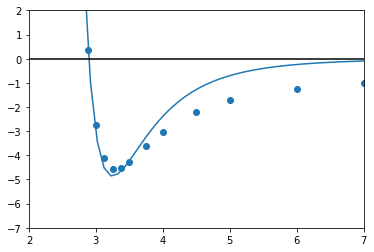

In [12]:
plt.xlim((2, 7))  # X limits
plt.ylim((-7, 2))  # Y limits
plt.scatter(distances, energies)  # Scatter plot of the distances/energies
plt.plot(fpoints, fit_energies)  # Fit data
plt.plot([0,10], [0,0], 'k-')  # Make a line at 0